In [1]:
import pandas as pd
from scapy.all import *

Library yang digunakan untuk melakukan ekstraksi data pada pcap

In [2]:
def extract_features(packet):
    # Inisialisasi nilai default
    inter_arrival_time = 0
    frequency_of_arrival = 0
    source_ip = 'N/A'
    dest_ip = 'N/A'
    throughput = 0

    # Cek apakah lapisan IP ada dalam paket
    if IP in packet:
        # Ekstraksi fitur: Inter-arrival time dan Frequency of arrival
        inter_arrival_time = packet.time - extract_features.last_packet_time
        extract_features.last_packet_time = packet.time
        frequency_of_arrival = 1 / inter_arrival_time if inter_arrival_time != 0 else 0

        # Ekstraksi sumber dan tujuan alamat IP
        source_ip = packet[IP].src
        dest_ip = packet[IP].dst

        # Ekstraksi throughput
        throughput = len(packet)

    # Deteksi apakah throughput tinggi atau rendah berdasarkan threshold
    label = 'attack' if throughput > extract_features.throughput_threshold else 'normal'

    return {
        'Inter-arrival time': inter_arrival_time,
        'Frequency of arrival (s)': frequency_of_arrival,
        'Throughput': throughput,
        'Source': source_ip,
        'Destination': dest_ip,
        'Label': label
    }

def process_pcap(file_path):
    # Inisialisasi variabel
    extract_features.last_packet_time = 0
    extract_features.throughput_threshold = 755.97

    # Membaca file pcap
    packets = rdpcap(file_path)

    # Ekstraksi fitur dari setiap paket
    features_list = [extract_features(packet) for packet in packets]

    # Membuat DataFrame dari hasil ekstraksi fitur
    df = pd.DataFrame(features_list)

    # Menyimpan DataFrame ke dalam file CSV
    df.to_csv('output_features.csv', index=False)

# Contoh pemanggilan fungsi
process_pcap('trace_2023_01_29_09_37_10.pcap5')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Library yang digunakan untuk melakukan data cleaning, EDA, dan Klasifikasi

In [4]:
#Load data output_features dan menampilkan 5 data teratasnya
df = pd.read_csv('output_features.csv')
df.head()

,Inter-arrival time,Frequency of arrival (s),Throughput,Source,Destination,Label
0,1.675041e+09,5.970005e-10,64468,10.10.1.198,142.251.10.95,attack
1,5.480000e-04,1.824818e+03,64468,10.10.1.198,142.251.10.95,attack
2,6.970000e-04,1.434720e+03,64468,10.10.1.198,142.251.10.95,attack
3,5.480000e-04,1.824818e+03,64468,10.10.1.198,142.251.10.95,attack
4,5.470000e-04,1.828154e+03,64468,10.10.1.198,142.251.10.95,attack


In [5]:
#Menampilkan 5 data terbawah
df.tail()

,Inter-arrival time,Frequency of arrival (s),Throughput,Source,Destination,Label
247816,0.000000,0.000000,96,142.251.10.95,10.10.1.198,normal
247817,0.000000,0.000000,96,142.251.10.95,10.10.1.198,normal
247818,0.000003,333333.333333,1292,10.10.1.198,142.251.10.95,attack
247819,0.000067,14925.373134,96,142.251.10.95,10.10.1.198,normal
247820,0.000000,0.000000,96,142.251.10.95,10.10.1.198,normal


In [6]:
#untuk memberikan informasi ringkas tentang sebuah DataFrame, termasuk informasi tentang tipe data, jumlah baris dan kolom, jumlah nilai yang tidak kosong, dan sebagainya.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247821 entries, 0 to 247820
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Inter-arrival time        247821 non-null  float64
 1   Frequency of arrival (s)  247821 non-null  float64
 2   Throughput                247821 non-null  int64  
 3   Source                    247485 non-null  object 
 4   Destination               247485 non-null  object 
 5   Label                     247821 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 11.3+ MB


In [7]:
#Menghitung jumlah missing value pada attribute
df.isnull().sum()

Inter-arrival time            0
Frequency of arrival (s)      0
Throughput                    0
Source                      336
Destination                 336
Label                         0
dtype: int64

In [8]:
#Handling missing value pada kolom 'Souce' dan 'Destination' dengan cara menghapus data dikarenakan jumlah missing value sedikit dibandingkan dengan keseluruhan data
df = df.dropna(subset=['Source', 'Destination'])

In [9]:
#Menghitung jumlah missing value pada attribute
df.isnull().sum()

Inter-arrival time          0
Frequency of arrival (s)    0
Throughput                  0
Source                      0
Destination                 0
Label                       0
dtype: int64

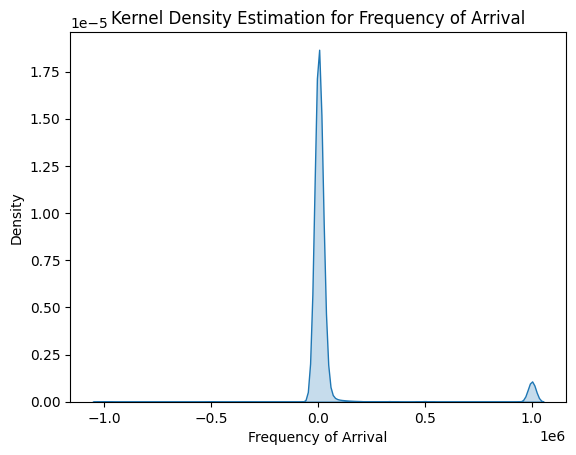

In [10]:
#Visualization : memvisualisasikan distribusi Plot untuk Frequency of Arrival.
#Jadi dengan adanya ini kita dapat mengidentifikasi apakah data cenderung berkumpul pada rentang tertentu atau apakah ada kecenderungan tertentu dalam frekuensi kedatangan

sns.kdeplot(df['Frequency of arrival (s)'], fill=True)
plt.xlabel('Frequency of Arrival')
plt.ylabel('Density')
plt.title('Kernel Density Estimation for Frequency of Arrival')
plt.show()

Text(0.5, 1.0, 'Distribution of Labels')

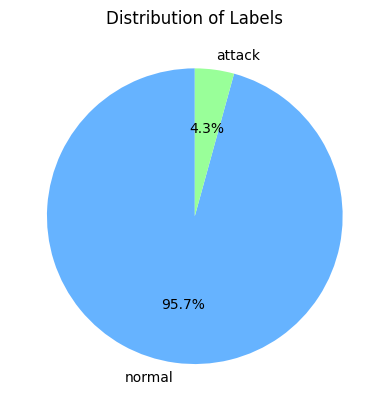

In [11]:
#Visualization : memvisualisasikan perbandingan jaringan normal dan terkena DDOS attack.
#Dengan adanya ini kita bisa mengetahui berapa presentase jaringan yang normal dan tidak normal. contohnya jaringan yang normal terdapat 95.7% dan 4.3% terkena serangan

label_counts = df['Label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])
plt.title('Distribution of Labels')

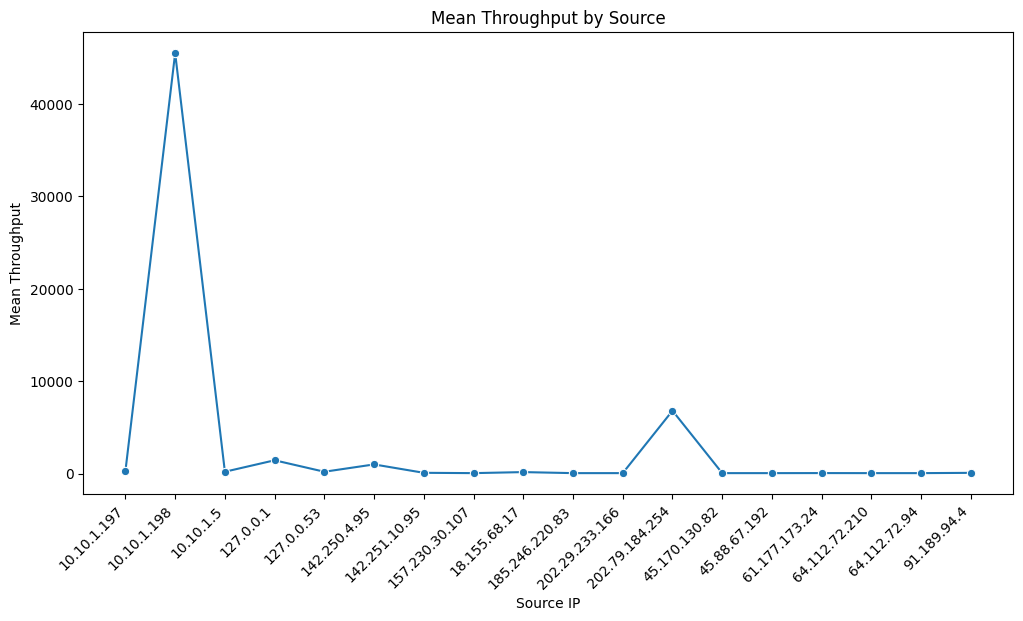

In [12]:
#Visualization :  memvisualisasikan rata-rata throughput dengan Source IP address
#Dengan adanya ini kita bisa mengetahui pada IP Source mana yang memiliki rata-rata throughput paling tinggi yaitu pada 10.10.1.198 dengan rata-rata lebih dari 40.000 yang berarti untuk terkena risiko DDOS lebih besar disbanding yang lain

# Mengelompokkan source ip address berdasarkan rata-rata throughput
grouped_source_df = df.groupby(['Source'])['Throughput'].mean().reset_index()

# Membuat line chart
plt.figure(figsize=(12, 6))

sns.lineplot(x='Source', y='Throughput', marker='o', data=grouped_source_df)
plt.xlabel('Source IP')
plt.ylabel('Mean Throughput')
plt.title('Mean Throughput by Source')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.show()


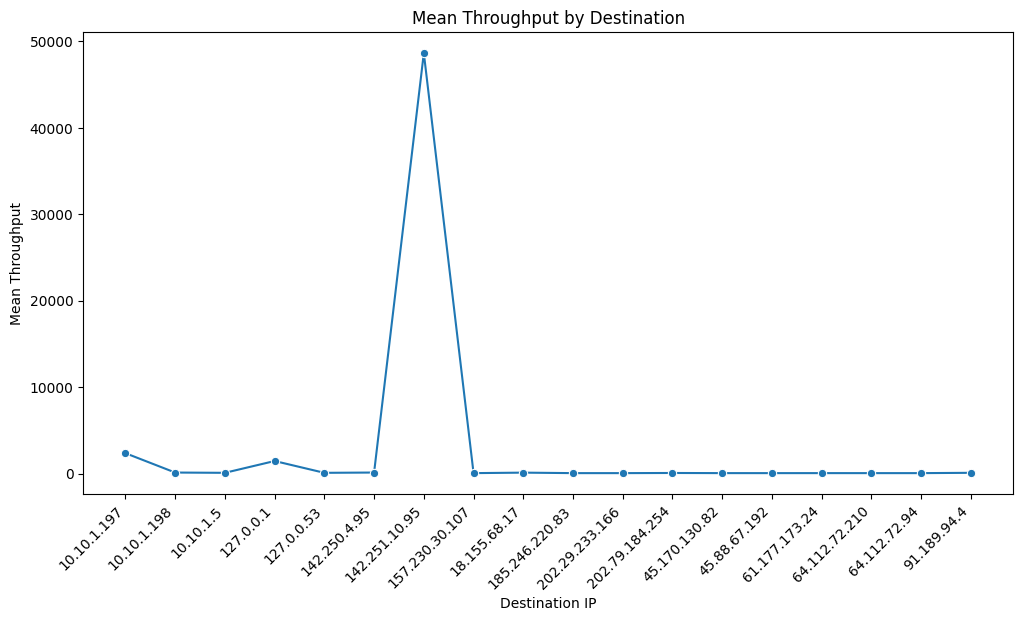

In [13]:
# Mengelompokkan destination ip address berdasarkan rata-rata throughput
grouped_source_df = df.groupby(['Destination'])['Throughput'].mean().reset_index()

# Membuat line chart
plt.figure(figsize=(12, 6))

sns.lineplot(x='Destination', y='Throughput', marker='o', data=grouped_source_df)
plt.xlabel('Destination IP')
plt.ylabel('Mean Throughput')
plt.title('Mean Throughput by Destination')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.show()

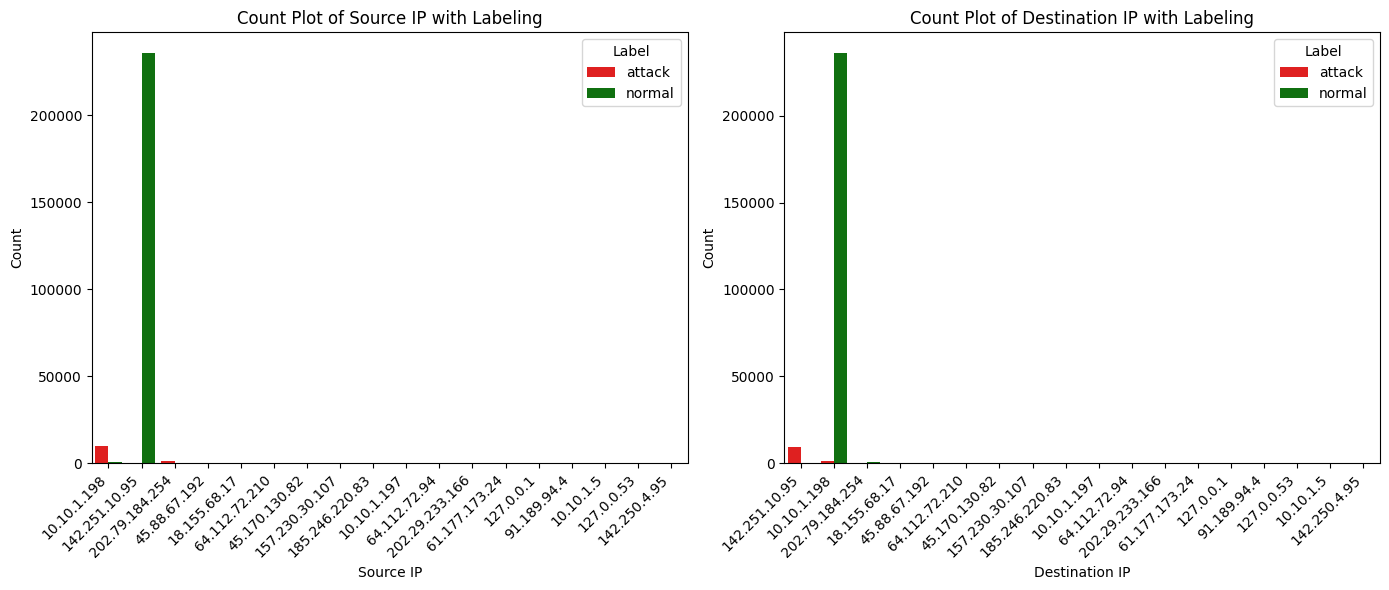

In [14]:
#Visualization : memvisualisasikan Count Plot untuk IP Source dan IP Destination dengan Labeling 
#Jadi dengan adanya ini kita dapat mengetahui jumlah serangan DDOS pada setiap Souce IP atau Destination IP. Contohnya pada Source IP yang berpotensi mendapat serangan DDOS paling banyak yaitu 10.10.1.198 sedangkan pada Destination IP yaitu 142.251.10.95

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Source', hue='Label', data=df, palette={'normal': 'green', 'attack': 'red'})
plt.xlabel('Source IP')
plt.ylabel('Count')
plt.title('Count Plot of Source IP with Labeling')
plt.legend(title='Label', loc='upper right')

plt.xticks(rotation=45, ha='right')  # Untuk memutar label sumbu x agar terbaca lebih baik

plt.subplot(1, 2, 2)
sns.countplot(x='Destination', hue='Label', data=df, palette={'normal': 'green', 'attack': 'red'})
plt.xlabel('Destination IP')
plt.ylabel('Count')
plt.title('Count Plot of Destination IP with Labeling')
plt.legend(title='Label', loc='upper right')

plt.xticks(rotation=45, ha='right')  # Untuk memutar label sumbu x agar terbaca lebih baik

plt.tight_layout()
plt.show()


In [15]:
# Fungsi konversi IP ke bilangan bulat
def ip_to_int(ip_address):
    octets = ip_address.split('.')
    return int(octets[0]) << 24 | int(octets[1]) << 16 | int(octets[2]) << 8 | int(octets[3])


# Terapkan fungsi ip_to_int pada kolom 'source' dan 'destination'
df['Source'] = df['Source'].apply(ip_to_int)
df['Destination'] = df['Destination'].apply(ip_to_int)

# Tampilkan DataFrame setelah perubahan
df

,Inter-arrival time,Frequency of arrival (s),Throughput,Source,Destination,Label
0,1.675041e+09,5.970005e-10,64468,168427974,2398816863,attack
1,5.480000e-04,1.824818e+03,64468,168427974,2398816863,attack
2,6.970000e-04,1.434720e+03,64468,168427974,2398816863,attack
3,5.480000e-04,1.824818e+03,64468,168427974,2398816863,attack
4,5.470000e-04,1.828154e+03,64468,168427974,2398816863,attack
...,...,...,...,...,...,...
247816,0.000000e+00,0.000000e+00,96,2398816863,168427974,normal
247817,0.000000e+00,0.000000e+00,96,2398816863,168427974,normal
247818,3.000000e-06,3.333333e+05,1292,168427974,2398816863,attack
247819,6.700000e-05,1.492537e+04,96,2398816863,168427974,normal


In [16]:
#Encoding data categorical pada label

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
df

,Inter-arrival time,Frequency of arrival (s),Throughput,Source,Destination,Label
0,1.675041e+09,5.970005e-10,64468,168427974,2398816863,0
1,5.480000e-04,1.824818e+03,64468,168427974,2398816863,0
2,6.970000e-04,1.434720e+03,64468,168427974,2398816863,0
3,5.480000e-04,1.824818e+03,64468,168427974,2398816863,0
4,5.470000e-04,1.828154e+03,64468,168427974,2398816863,0
...,...,...,...,...,...,...
247816,0.000000e+00,0.000000e+00,96,2398816863,168427974,1
247817,0.000000e+00,0.000000e+00,96,2398816863,168427974,1
247818,3.000000e-06,3.333333e+05,1292,168427974,2398816863,0
247819,6.700000e-05,1.492537e+04,96,2398816863,168427974,1


In [17]:
# Memisahkan fitur dan label
X = df.drop('Label', axis=1)
y = df['Label']

#Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Apply SMOTE for class imbalance
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)

In [19]:
# Modelling menggunakan Naive Bayes
model2 =GaussianNB()
model2.fit(X_resampled, y_resampled)

GaussianNB()

In [20]:
y_pred2 = model2.predict(X_test)

In [21]:
print('Classification Report:')
print(classification_report(y_test, y_pred2, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9203    0.9991    0.9580      2160
           1     1.0000    0.9960    0.9980     47337

    accuracy                         0.9962     49497
   macro avg     0.9601    0.9976    0.9780     49497
weighted avg     0.9965    0.9962    0.9963     49497



In [22]:
# Modelling menggunakan KNN
model3 = KNeighborsClassifier(n_neighbors=5)
model3.fit(X_resampled, y_resampled)

KNeighborsClassifier()

In [23]:
y_pred3 = model3.predict(X_test)

In [24]:
print('Classification Report:')
print(classification_report(y_test, y_pred3, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9954    0.9981    0.9968      2160
           1     0.9999    0.9998    0.9999     47337

    accuracy                         0.9997     49497
   macro avg     0.9976    0.9990    0.9983     49497
weighted avg     0.9997    0.9997    0.9997     49497

